<h1 style="text-align:center">Problem 6.21</h1>
<h3 style="text-align:center">MCHE 513: Intermediate Dynamics</h3> 
<p style="text-align:center">Dr. Joshua Vaughan <br>
<a href="mailto:joshua.vaughan@louisiana.edu">joshua.vaughan@louisiana.edu</a><br>
<a href="http://www.ucs.louisiana.edu/~jev9637/">http://www.ucs.louisiana.edu/~jev9637/</a></p>`

The problem asks to form the equations of motion for an unbalanced rolling cylinder, with eccentricity $\epsilon$ and radius $R$. There is enough friction such that pure rolling (no slip) is maintained. The system is sketched in Figure 1.

<p style="text-align:center">
	<img src="http://shared.crawlab.org/rolling_imbalanced_Prob6p21.png" alt="Rolling Cylinder with Imbalance" width=50%><br>
    <strong>Figure 1: Rolling Cylinder with Imbalance</strong>
</p>

In [19]:
# Import the SymPy Module
import sympy

# Import the necessary sub-modules and methods for dynamics
from sympy.physics.mechanics import dynamicsymbols, inertia
from sympy.physics.mechanics import LagrangesMethod, Lagrangian
from sympy.physics.mechanics import Particle, Point, ReferenceFrame, RigidBody

# initiate better printing of SymPy results
sympy.init_printing()

In [20]:
# Define the generalized coordinates - just 1DOF here
theta = dynamicsymbols('theta')
theta_dot = dynamicsymbols('theta', 1)

# Define the other symbols needed
R, e, m, g, Izz, t = sympy.symbols('R epsilon m g I_{zz} t')

In [21]:
# Define the Newtonian reference frame
N = ReferenceFrame('N')

# Define a body-fixed frame along the pendulum, with y aligned from m to the pin
P = N.orientnew('P', 'Axis', [-theta, N.z])

# Define the point at the center of the cylinder and set its velocity
A = Point('A')
A.set_vel(N, R * theta_dot * N.x) # Pure rolling

In [22]:
# Locate the center of mass relative to the cylinder center
G = A.locatenew('G', -e * (sympy.sin(theta) * N.x + sympy.cos(theta) * N.y))

# Define its velocity, working from the velocity of point A - needed for kinetic energy calculation
G.v2pt_theory(A, N, P)

In [23]:
# Create the inertia diadic for the cylinder. 
# Since the system is planar, set Ixx and Iyy to zero for simplicity
Ic = inertia(P, 0, 0, Izz)

# Define the cylinder as a rigid body
cylinder = RigidBody('cylinder', G, P, m, (Ic, G))

# Define the potential energy of the cyliner - just gravity here
cylinder.set_potential_energy(-m * g * e * sympy.cos(theta))

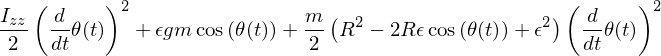

In [24]:
# Form the Lagrangian, then simplify and print
L = Lagrangian(N, cylinder)
L.simplify()

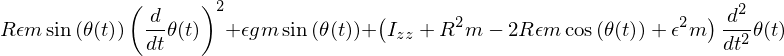

In [25]:
# create an instance of the LagrangesMethod class
LM = LagrangesMethod(L, [theta])

# Form the equations of motion, then simplify and print
eq_of_motion = LM.form_lagranges_equations()
sympy.collect(sympy.simplify(eq_of_motion)[0], theta)

## Simulation
We can pass these equations of motion to numerical solver for simluation. To do so, we need to import [NumPy](http://numpy.org) and the [SciPy](http://www.scipy.org) ode solver, ```ode```. We'll also import [matplotlib](http://www.scipy.org) to enable plotting of the results.

For a system as simple as this one, we could easily set up the necessary components for the numerical simulation manually. However, here we will automate as much as possible. Following a similar procedure on more complicated systems would be necessary.

In [26]:
# import NumPy with namespace np
import numpy as np

# import the ode ODE solver
from scipy.integrate import ode

# import the plotting functions from matplotlib
import matplotlib.pyplot as plt

# set up the notebook to display the plots inline
%matplotlib inline

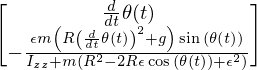

In [42]:
# Make the call to set up in state-space-ish form q_dot = f(q, t)
lrhs = LM.rhs()

# Simplify the results
lrhs.simplify()

# Output the result
lrhs

In [47]:
# Define the states and state vector
w1, w2 = sympy.symbols('w1 w2', cls=sympy.Function)
w = [w1(t), w2(t)]

# Set up the state definitions and parameter substitution
sub_params = {theta: w1(t), 
              theta_dot: w2(t), 
              g : 9.81, 
              e : 0.5,
              R : 1.0,
              m : 10.0,
              Izz : 0.5 * (0.9 * m) * R**2 + (0.1 * m) * e**2}


# set this parameter to enable array output from sympy.lambdify
mat2array = [{'ImmutableMatrix': np.array}, 'numpy']

# Create a function from the equations of motion
# Here, we substitude the states and parameters as appropriate prior to the lamdification
eq_of_motion = sympy.lambdify((t, w), 
                              lrhs.subs(sub_params), 
                              modules = mat2array)

In [84]:
# Set up the initial conditions for the solver
theta_init = 225 * np.pi/180     # Initial angle
theta_dot_init = 0           # Initial angular velocity

# Pack the initial conditions into an array
x0 = [theta_init, theta_dot_init]

# Create the time samples for the output of the ODE solver
sim_time = np.linspace(0.0, 10.0, 1001) # 0-10s with 1001 points in between

In [85]:
# Set up the initial point for the ode solver
r = ode(eq_of_motion).set_initial_value(x0, sim_time[0])
 
# define the sample time
dt = sim_time[1] - sim_time[0]   

# pre-populate the response array with zeros
response = np.zeros((len(sim_time), len(x0)))

# Set the initial index to 0
index = 0

# Now, numerically integrate the ODE while:
#   1. the last step was successful
#   2. the current time is less than the desired simluation end time
while r.successful() and r.t < sim_time[-1]:
    response[index, :] = r.y
    r.integrate(r.t + dt)
    index += 1

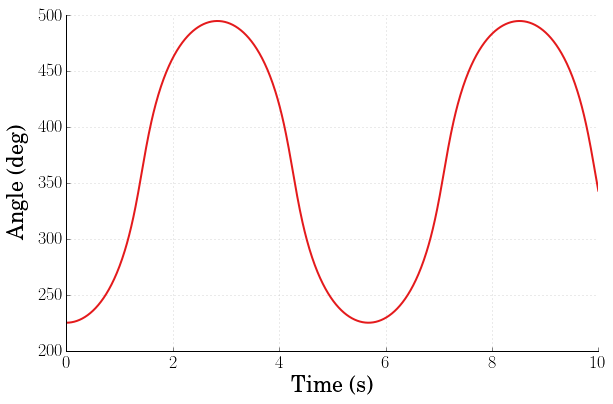

In [86]:
# Set the plot size - 3x2 aspect ratio is best
fig = plt.figure(figsize=(6, 4))
ax = plt.gca()
plt.subplots_adjust(bottom=0.17, left=0.17, top=0.96, right=0.96)

# Change the axis units to serif
plt.setp(ax.get_ymajorticklabels(), family='serif', fontsize=18)
plt.setp(ax.get_xmajorticklabels(), family='serif', fontsize=18)

# Remove top and right axes border
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')

# Only show axes ticks on the bottom and left axes
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

# Turn on the plot grid and set appropriate linestyle and color
ax.grid(True,linestyle=':', color='0.75')
ax.set_axisbelow(True)

# Define the X and Y axis labels
plt.xlabel('Time (s)', family='serif', fontsize=22, weight='bold', labelpad=5)
plt.ylabel('Angle (deg)', family='serif', fontsize=22, weight='bold', labelpad=10)

# Plot the data
plt.plot(sim_time, response[:, 0] * 180/np.pi, linewidth=2, linestyle='-', label = '$\theta$')

# uncomment below and set limits if needed
# plt.xlim(0, 5)
# plt.ylim(-1, 1)

# Create the legend, then fix the fontsize
# leg = plt.legend(loc='upper right', ncol = 1, fancybox=True)
# ltext  = leg.get_texts()
# plt.setp(ltext, family='serif', fontsize=20)

# Adjust the page layout filling the page using the new tight_layout command
plt.tight_layout(pad=0.5)

# Uncomment to save the figure as a high-res pdf in the current folder
# It's saved at the original 6x4 size
# plt.savefig('Simple_Pendulum_Response.pdf')

fig.set_size_inches(9, 6) # Resize the figure for better display in the notebook

Let's plot the planar position of the center of mass.

In [87]:
x = 2 * 1.0 * np.pi * response[:,0] - 0.1 * np.sin(response[:,0])
y = -0.1 * np.cos(response[:,0])

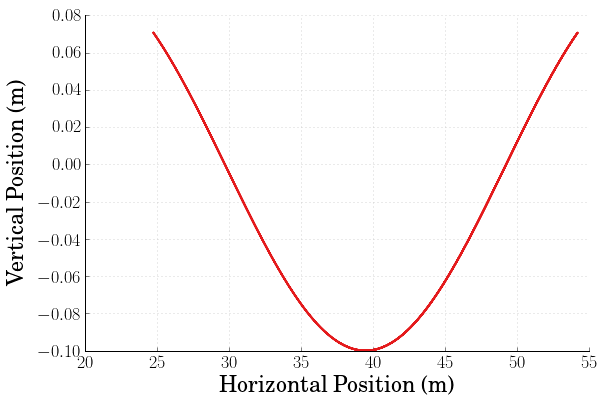

In [88]:
# Set the plot size - 3x2 aspect ratio is best
fig = plt.figure(figsize=(6, 4))
ax = plt.gca()
plt.subplots_adjust(bottom=0.17, left=0.17, top=0.96, right=0.96)

# Change the axis units to serif
plt.setp(ax.get_ymajorticklabels(), family='serif', fontsize=18)
plt.setp(ax.get_xmajorticklabels(), family='serif', fontsize=18)

# Remove top and right axes border
ax.spines['right'].set_color('none')
ax.spines['top'].set_color('none')

# Only show axes ticks on the bottom and left axes
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

# Turn on the plot grid and set appropriate linestyle and color
ax.grid(True,linestyle=':', color='0.75')
ax.set_axisbelow(True)

# Define the X and Y axis labels
plt.xlabel('Horizontal Position (m)', family='serif', fontsize=22, weight='bold', labelpad=5)
plt.ylabel('Vertical Position (m)', family='serif', fontsize=22, weight='bold', labelpad=10)

# Plot the data
plt.plot(x, y, linewidth=2, linestyle='-')

# uncomment below and set limits if needed
# plt.xlim(-1, 1)
# plt.ylim(1.25*np.min(y), 0.01)

# Adjust the page layout filling the page using the new tight_layout command
plt.tight_layout(pad=0.5)

# Uncomment to save the figure as a high-res pdf in the current folder
# It's saved at the original 6x4 size
# plt.savefig('Spring_Pendulum_Response_Planar.pdf')

fig.set_size_inches(9, 6) # Resize the figure for better display in the notebook

<hr class = "style-end">

#### Licenses
Code is licensed under a 3-clause BSD style license. See the licenses/LICENSE.md file.

Other content is provided under a [Creative Commons Attribution-NonCommercial 4.0 International License](http://creativecommons.org/licenses/by-nc/4.0/), CC-BY-NC 4.0.

In [89]:
# Ignore this cell - We just update the CSS to make the notebook look a little bit better and easier to read

# Improve the notebook styling -- Run this first
import codecs
from IPython.core.display import HTML
css_file = 'styling/CRAWLAB_IPythonNotebook.css'
HTML(codecs.open(css_file, 'r', 'utf-8').read())